Como ENGENHEIRO DE RESERVATÓRIO quero PREVER A PRODUÇÃO DE ÓLEO UM POÇO BASEADO EM SEU HISTÓRICO para TOMAR DECISÕES DE PRIORIZAÇÃO E CUMPRIR COMPROMISSOS LEGAIS.

# Trabalho Final da Discilpina de Engenharia de Software para CD - PUC-Rio

Professor: Marcos Kalinowski

Aluno: Pedro Henrique Cardoso Paulo

Data limite de entrega: 07 de junho de 2023

## Definição do problema

### Motivação

A previsão de produção de óleo ao longo do tempo é uma necessidade de qualquer operador da indústria de O&G, quer seja por obrigações legais, quer seja para poder gerenciar de forma mais adequada suas reservas. Embora essa tarefa seja corriqueiramente feita no dia-a-dia de um engenheiro de reservatórios por meio da manutenção e ajuste de modelos de simulação paa representar o histórico de produção, essa abordagem tende a ser custosa em termos de tempo, de modo que abordagens data-driven são desejáveis.

### Dataset

![fig:dataset_example](./images/data_example.png)

O Volve Dataset é uma base de dados aberta contendo dados geológicos e de histórico de produção do campo de Volve. O campo foi operado pela Equinor entre 2008 e 2016, quando sua produção foi encerrada. Em 2018 as facilidades de produção do compo foram removidas.

A parte de interesse para o presente estudo do Volve Dataset são os dados do histórico de produção de seus poços, que consistem em valores ao longo do tempo (normalmente médias diárias) de pressão, temperatura, abertura de válvulas e de vazões das três fases (água, óleo e gás) de fluido produzidas pelo poço. No total, o dataset contém dados de seis poços produtores e um poço injetor.

#### Características do dado

* Dado de caráter TEMPORAL
* Dado com amostragem diária

#### Poço de referência

* `15/9-F-1 C`

#### Variáveis de entrada

* `AVG_DOWNHOLE_PRESSURE`: Pressão média no fundo do poço de um dia (bar)
* `AVG_WHP_P`: Pressão média na cabeça do poço ao longo de um dia (bar)
* `AVG_CHOKE_SIZE_P`: Abertura do choke em percentual da abertura plena (também média ao longo do dia) (%)
* `AVG_WHT_P`: Temperatura média na cabeça de poço ao longo de um dia (°C)
* `AVG_DOWNHOLE_TEMPERATURE`: Temperatura média no fundo do poço de um dia (°C)

#### Variáveis de saída

* `BORE_OIL_VOL`: Vazão de óleo média no dia (Sm3/d) - Output desejado
* `BORE_WAT_VOL`: Vazão de água média no dia (Sm3/d)
* `BORE_GAS_VOL`: Vazão de gás média no dia (kSm3/d)

### Classificação do problema

Com base nos tipos de dados e na saída desejada, vê-se que é um problema de APRENDIZADO SUPERVISIONADO (REGRESSÃO)

## Objetivo

O objetivo do projeto é fazer um modelo data-driven capaz de realizar predições de produção de óleo de um poço a partir de seu histórico de produção.

### User Story

Como ENGENHEIRO DE RESERVATÓRIO quero PREVER A PRODUÇÃO DE ÓLEO UM POÇO BASEADO EM SEU HISTÓRICO para TOMAR DECISÕES DE PRIORIZAÇÃO E CUMPRIR COMPROMISSOS LEGAIS.

## Pacotes utilizados

Aqui estão concentrados os imports dos pacotes importantes para a execução dos notebook. Também nesta célula será fixada a random seed que garantirá a repetibilidade do notebook.

In [22]:
# Pacotes padrao
import copy
import json
import datetime
import pickle as pkl
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

#Busca de modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, KFold, cross_val_score

# Scores
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

# Disabling warnings
import warnings
warnings.filterwarnings("ignore")

#Definindo random_state (repetibilidade)
rs = 85

## Classes e Objetos

Embora seja recomendado que todas as classes do projeto sejam declaradas ou em arquivo `.py` externo ou no início do notebook, nesse caso elas serão declaradas no início da etapa em que se fazem mais úteis.

## Coleta e análise de dados

Nesta etapa serão feitas a análise exploratória dos dados e criada a classe de leitura de dados.

### Base para consumo de dados

O cliente forneceu um compilado do dataset em arquivos `.json` contendo a curva de cada poço e um arquivo e um arquivo de metadados `metadata.json` que associa cada arquivo a seu poço. A base fornecida pode ser visualizada nesta [pasta](./data), no mesmo repositório que o notebook.


### Classe de leitura dos dados

Aqui será implementada a classe `DataLoader`, com função de leitura dos dados de um poço e extração das variáveis relevantes. O procedimento de leitura e documentação dos metadados foi fornecido pelo cliente.

In [23]:
class DataLoader:

    def __init__(self, base_path='.'):
        """Build the DataLoader class. Takes only the base path
        where to find the data as an input.

        Args:
            base_path (str, optional): Base path yo get the  desierd
            data. Defaults to '.'.
        """

        self.base_path = base_path
        self.load_metadata(self.base_path)

    def load_metadata(self, path):
        """Loads the metadata from the dataset, that allows the query
        for the data od an specific well.

        Args:
            path (str): Path where to find the metadata
        """
        
        with open(path + '/metadata.json', 'r') as metafile:
            self.metadata = json.loads(metafile.read())

    def load_data(self, well, variables=None):
        """Loads the data of a given well in the dataset

        Args:
            well (str): Name of the well to be taken from the dataset
            variables (List[str]|None): Variables list to be taken form the dataset.
            in case of None, returns all variables form dataset. Defaults to None

        Returns:
            data (pd.DataFrame): Dataframe containing the data frm the well
        """

        # Getting the well INDEX using the parsed metadata
        try:
            well_index = [meta['INDEX'] for meta in self.metadata if meta['WELL'] == well][0]
        except Exception as e:
            print('No data loaded!')
            return None
        
        # Reading data and filtering the columns
        data = pd.read_json(f'{self.base_path}/{well_index}.json')
        data['BORE_LIQ_VOL'] = data['BORE_OIL_VOL'] + data['BORE_WAT_VOL']
        if not variables is None:
            data = data[variables]
        
        return data

### Carregamento dos dados

A primeira etapa será ao carregamento da totalidade dos dados do poço (sem focar nas colunas desejadas) para verificar se todas as variáveis relevantes estão contidas no dataset

In [24]:
path = './data'
well = '15/9-F-1 C'
# Carregando o dado
dataloader = DataLoader(base_path=path)
well_data = dataloader.load_data(well=well)

In [25]:
# Visualizando as 30 primeiras linhas
display(well_data.head(30))

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,BORE_LIQ_VOL
0,0.000,0.000,0.000,0.0,0.00000,0.000,0.000,0.000,0.000,0.000,0.0,NaN,0.000
1,NaN,NaN,NaN,0.0,1.00306,0.000,0.000,0.000,0.000,0.000,0.0,NaN,0.000
2,NaN,NaN,NaN,0.0,0.97901,0.000,0.000,0.000,0.000,0.000,0.0,NaN,0.000
3,NaN,NaN,NaN,0.0,0.54576,0.000,0.000,0.000,0.000,0.000,0.0,NaN,0.000
4,310.376,96.876,277.278,0.0,1.21599,33.098,10.480,33.072,0.000,0.000,0.0,NaN,0.000
5,303.501,96.923,281.447,0.0,3.08702,22.053,8.704,22.053,0.000,0.000,0.0,NaN,0.000
6,303.535,96.959,276.032,0.0,1.96237,27.503,9.423,16.163,0.000,0.000,0.0,NaN,0.000
7,303.782,96.969,282.787,0.0,0.00000,20.996,8.131,20.737,0.000,0.000,0.0,NaN,0.000
8,303.858,97.021,289.941,0.0,31.14186,13.918,8.498,12.182,0.000,0.000,0.0,NaN,0.000
9,303.792,97.066,299.672,0.0,0.00000,4.120,8.821,1.490,0.000,0.000,0.0,NaN,0.000


Como podemos ver, todas as variáveis listadas na definição do problema estão no dataset. Dessa forma, repetimos seu carregamento, agora pegando apenas as variáveis de interesse.

In [26]:
input_variables = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        'AVG_CHOKE_SIZE_P',
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

output_variables = [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        'BORE_LIQ_VOL',
]

well_data = dataloader.load_data(well=well, variables=input_variables+output_variables)

### Exploração e Análise de dados

Nesta etapa vamos começar a realizar uma análise exploratória de dados, vislumbrando sua qualidade e planejando o tratamento futuro. Primeiro, vamos ver os dados tabulares:

In [27]:
display(well_data.head(30))

,AVG_DOWNHOLE_PRESSURE,AVG_WHP_P,AVG_CHOKE_SIZE_P,AVG_WHT_P,AVG_DOWNHOLE_TEMPERATURE,BORE_LIQ_VOL
0,0.000,0.000,0.00000,0.000,0.000,0.000
1,NaN,0.000,1.00306,0.000,NaN,0.000
2,NaN,0.000,0.97901,0.000,NaN,0.000
3,NaN,0.000,0.54576,0.000,NaN,0.000
4,310.376,33.098,1.21599,10.480,96.876,0.000
5,303.501,22.053,3.08702,8.704,96.923,0.000
6,303.535,27.503,1.96237,9.423,96.959,0.000
7,303.782,20.996,0.00000,8.131,96.969,0.000
8,303.858,13.918,31.14186,8.498,97.021,0.000
9,303.792,4.120,0.00000,8.821,97.066,0.000


Já é possível ver que o dataset contém alguns valores NaN. Além disso, há uma linha com valores zerados no corpo do dataset, o que sabe-se ser impossível para o problema em questão (embora vazão zero seja possível e seja uma condição de interesse de se pegar, pressão de fundotemperatura de fundo zero são condições impossíveis para o tipo de problema). Em seguida, vemos um resumo das características dos inputs e outputs:

In [28]:
well_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AVG_DOWNHOLE_PRESSURE     743 non-null    float64
 1   AVG_WHP_P                 746 non-null    float64
 2   AVG_CHOKE_SIZE_P          746 non-null    float64
 3   AVG_WHT_P                 746 non-null    float64
 4   AVG_DOWNHOLE_TEMPERATURE  743 non-null    float64
 5   BORE_LIQ_VOL              746 non-null    float64
dtypes: float64(6)
memory usage: 35.1 KB


Aqui vemos que, embora haja valores NaN, estes correspondem apenas Às três primeiras linhas do dataset. Como estamos falando de 3 linhas em um universo de 746 totais (< 0.5 %), eliminar esses registros é uma opção viável. Fazendo uma rápida busca pelas linhas que tem apenas zeros usando a sintaxe do pandas:

In [29]:
well_data.loc[(well_data==0).all(axis=1)]

,AVG_DOWNHOLE_PRESSURE,AVG_WHP_P,AVG_CHOKE_SIZE_P,AVG_WHT_P,AVG_DOWNHOLE_TEMPERATURE,BORE_LIQ_VOL
0,0.0,0.0,0.0,0.0,0.0,0.0
745,0.0,0.0,0.0,0.0,0.0,0.0


Novamente, vemos que essas linhas são poucas frente o dataset inteiro, de modo que podemos optar por eliminá-las. Além disso, como estão apenas no início e fim da série, parece que foram algum erro do processamento feito antes deste trabalho para gerar os `.json`. Por fim, aplicando o método `describe` para ter uma noção da ordem de grandeza dos dados (removendo a linha de zeros para não influenciar na estatística):

In [30]:
well_data.loc[~(well_data==0).all(axis=1)].describe()

,AVG_DOWNHOLE_PRESSURE,AVG_WHP_P,AVG_CHOKE_SIZE_P,AVG_WHT_P,AVG_DOWNHOLE_TEMPERATURE,BORE_LIQ_VOL
count,741.000000,744.000000,744.000000,744.000000,741.000000,744.000000
mean,247.331802,54.053063,29.678017,40.517668,105.208502,453.088659
std,27.989949,32.892551,25.470984,26.066685,3.444302,467.955423
min,207.219000,0.000000,0.000000,0.000000,95.876000,0.000000
25%,220.902000,32.232000,0.029075,11.246500,101.291000,0.000000
50%,240.736000,43.282000,46.677255,53.322000,107.821000,413.500000
75%,271.298000,75.030250,51.192270,62.389250,108.140000,804.750000
max,313.871000,133.593000,93.635430,83.420000,108.502000,1712.000000


Aqui vemos que há uma diferença de ordens de grandeza entre certas variáveis do dado, porém esta não supera uma ordem de grandeza. A princípio, não se vê grande problema em manter os dados em escala, mas técnicas de adimensionalização seão também testadas. Por fim. visualizando os dados como a série temporal que são:

<Axes: >

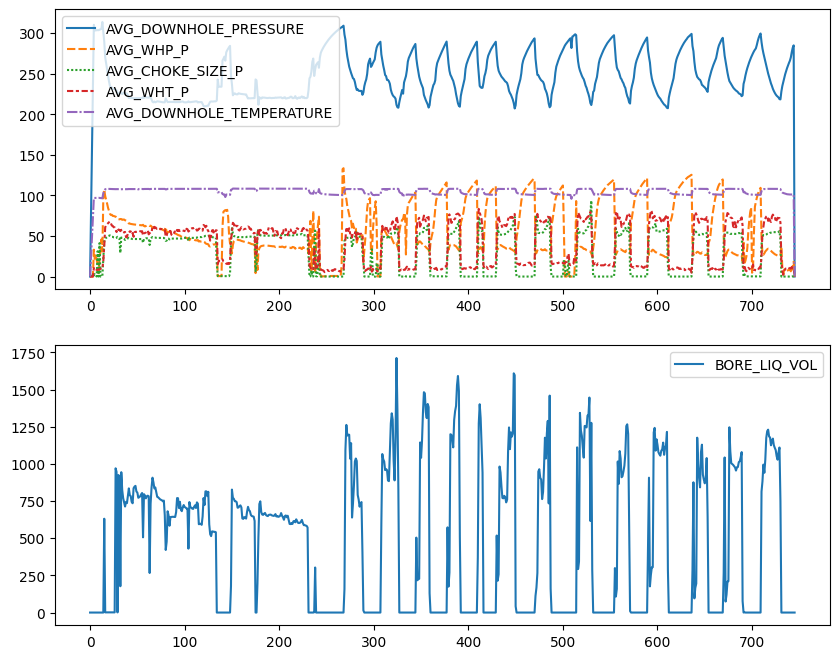

In [31]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
sns.lineplot(well_data[input_variables], ax=ax[0])
sns.lineplot(well_data[output_variables], ax=ax[1])


## Pré-processamento

Nessa etapa será implementada uma classe que permita automatizar o pré-processamento vislumbrado no item anterior. Essas etapas incluem:

* Eliminar os valores NaN
* Eliminar as linhas inteiramente zeradas

A classe também será a responsável pela separação de variáveis de entrada e de saída (com base nas listas já definidas) e da separação dos dados em treino e teste. Como nosso dado é temporal, treino e teste devem ser conjuntos contínuos do dataset, então não será usada a facilidade interna da biblioteca sklearn (`train_test_split`). Ao invés disso, a separação será com base na ordem das entradas.

Como estamos dando a essa classe muitas responsabilidades, vamos quebrá-las em três classes utilizáveis, com interface padronizada, das quais a classe final herdará. Abaixo segue a implementação:

In [32]:
class PreProcessor:
    """
    Parent class for all the preprocessors
    """

    def preprocess(self, dataset):
        """Method that performs the preprocessing of the dataset

        Args:
            dataset (pd.DataFrame): The datset
        """

        pass


class CleanDataPreProcessor(PreProcessor):
    """
    Preprocessor responsible for cleaning the data
    """

    def preprocess(self, dataset):

        dataset = self.__clean_dataset(dataset)
        
        return dataset

    def __clean_dataset(self, dataset):

        dataset = dataset.dropna()
        dataset = dataset.loc[~(dataset==0).all(axis=1)]
        return dataset
    

class HoldoutSeparatorPreProcessor(PreProcessor):
    """
    Preprocessor responsible for train test split.
    Takes the holdout as argument and stores as a parameter.
    """

    def __init__(self, holdout):

        self.set_holdout(holdout)

    def set_holdout(self, holdout):

        self.holdout = holdout

    def preprocess(self, dataset):

        dataset_train, dataset_test = self.__holdout(dataset, self.holdout)

        return dataset_train, dataset_test

    def __holdout(self, dataset, holdout):
        
        total_samples = len(dataset)
        train_samples = int(total_samples*(1.0-holdout))
        dataset_train = dataset.iloc[:train_samples,:]
        dataset_test = dataset.iloc[train_samples:,:]

        return dataset_train, dataset_test


class IOSplitPreProcessor(PreProcessor):
    """
    Preprocessor responsible for splitting input and output.
    Takes the name of the variables as inputs.
    """

    def __init__(self, input_variables = [], output_variables = []):

        self.set_io_variables(input_variables, output_variables)

    def set_io_variables(self, input_variables = [], output_variables = []):

        self.input_variables = input_variables
        self.output_variables = output_variables

    def preprocess(self, dataset):
        
        X, y = self.__separate_input_output(dataset, self.input_variables, self.output_variables)

        return X, y

    def __separate_input_output(self, dataset, input_variables, output_variables):

        X = dataset[input_variables].values
        y = dataset[output_variables].values.ravel()

        return X, y


class WellDataPreProcessor(CleanDataPreProcessor, HoldoutSeparatorPreProcessor, IOSplitPreProcessor):
    """
    Preprocessor that contemplates all the steps for the dataset.
    """

    def __init__(self, holdout, input_variables, output_variables, clean_data=True):

        self.set_clean_data(clean_data)

        CleanDataPreProcessor.__init__(self)
        HoldoutSeparatorPreProcessor.__init__(self, holdout)
        IOSplitPreProcessor.__init__(self, input_variables, output_variables)
    
    def set_clean_data(self, clean_data):

        self.clean_data = clean_data

    def preprocess(self, dataset):

        if self.clean_data:
            dataset = CleanDataPreProcessor.preprocess(self, dataset)
        dataset_train, dataset_test = HoldoutSeparatorPreProcessor.preprocess(self, dataset)
        X_train, y_train = IOSplitPreProcessor.preprocess(self, dataset_train)
        X_test, y_test = IOSplitPreProcessor.preprocess(self, dataset_test)

        return X_train, y_train, X_test, y_test


Vamos aqui instanciar a classe e fazer alguns testes:

In [33]:
preprocessor = WellDataPreProcessor(holdout=0.3, input_variables=input_variables, output_variables=output_variables)
X_train, y_train, X_test, y_test = preprocessor.preprocess(well_data)

In [34]:
display(y_train)

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 6.31000e+02, 1.16600e+00, 1.55000e+00, 1.24900e+00,
       1.34600e+00, 1.35000e+00, 1.34600e+00, 1.27900e+00, 1.22600e+00,
       1.21300e+00, 1.07400e+00, 1.04400e+00, 9.70000e+02, 9.46000e+02,
       1.00300e+00, 9.25000e+02, 9.14000e+02, 1.77000e+02, 9.44000e+02,
       8.23000e+02, 7.69000e+02, 7.41000e+02, 7.13000e+02, 7.44000e+02,
       7.36000e+02, 7.83000e+02, 8.35000e+02, 7.89000e+02, 7.83000e+02,
       7.44000e+02, 7.35000e+02, 8.36000e+02, 8.47000e+02, 8.52000e+02,
       8.14000e+02, 8.07000e+02, 7.72000e+02, 7.76000e+02, 7.82000e+02,
       7.95000e+02, 8.04000e+02, 5.06000e+02, 7.96000e+02, 7.87000e+02,
       7.68000e+02, 7.82000e+02, 7.86000e+02, 7.82000e+02, 2.66000e+02,
       7.32000e+02, 8.40000e+02, 9.07000e+02, 8.76000e+02, 8.35000e+02,
       8.41000e+02, 8.09000e+02, 7.78000e+02, 7.75000e+02, 7.680

In [35]:
scale_X = MinMaxScaler()
scale_y = MinMaxScaler()

X_train = scale_X.fit_transform(X_train)
X_test = scale_X.transform(X_test)
y_train = scale_y.fit_transform(y_train.reshape(-1,1)).ravel()
y_test = scale_y.transform(y_test.reshape(-1,1)).ravel()

In [36]:
print(len(y_train), len(y_test))

518 223


Os resultados parecem sãos, então seguimos para a próxima etapa.

## Modelagem e inferência

Nesta seção serão listados os modelos de interesse, definidos ranges de hiperparâmetros, e métricas. Serão também implementadas as classes necessárias para a execução dos procedimentos e encpsulamento de código.

### Definição dos modelos e pipelines

Vamos padronizar nossa entrada para todas as avaliações como uma lista de tuplas para avaliar múltiplos modelos, seguindo o seguinte formato:

```(python)
lista_de_duplas = [
    ('Nome_Do_Modelo', objeto_do_modelo, dicionario_de_hiperparametros),
    ('Nome_Do_Modelo', objeto_do_modelo, dicionario_de_hiperparametros),
    ...
]
```

O objeto do modelo será um `Pipeline` composto de um modelo ou de um modelo com um adimensionalizador antes. O padrão de nome adotado para os modelos será sempre `'{nome_do_adimensionalizador_caso_haja}_{nome_do_regressor}'`. O dicionário de hiperparêmetros terá os valores a serem testados em uma eventual busca randômica ou então o resultado dessa busca (em caso de saída do processo).

Antes de montar efetivamente os piplines, começaremos declarando os modelos considerados pertinentes:

In [37]:
models_ml = [
    ('LinReg'          ,      LinearRegression(copy_X=True)),
    ('PolyReg'         ,      Pipeline([('Expander', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])),
    ('SVM'             ,      SVR(max_iter=-1)),
    ('KNN'             ,      KNeighborsRegressor()),
    ('DecisionTree'    ,      DecisionTreeRegressor(random_state=rs)),
    ('RandomForest'    ,      RandomForestRegressor(random_state=rs)),
    ('GradientBoosting',      GradientBoostingRegressor(random_state=rs)),
    ('ExtraTrees'      ,      ExtraTreesRegressor(random_state=rs)),
    ('MLP'             ,      MLPRegressor(random_state=rs, )),
]

Em seguida, declaramos os dicionários de hiperparâmetros a serem testados. Aqui assumimos que iremos aplicar uma busca randômica, então podemos (e devemos) usar modelos estatísticos (`scipy.stats`) como inputs da busca:

In [38]:
model_parameters = [
    {
        'LinReg__positive'                     : [True, False],
    },
    {
        'PolyReg__Reg__positive'                : [True, False],
        'PolyReg__Expander__degree'             : [2, 3],
    },
    {
        'SVM__C'                     : stats.loguniform(1e-3, 1e3),
        'SVM__kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'SVM__degree'                : stats.randint(2,6),
        'SVM__gamma'                 : stats.loguniform(1e-4, 1e0),
    },
    {
        'KNN__n_neighbors'           : stats.randint(1,100),
        'KNN__weights'               : ['uniform', 'distance'],

    },
    {

        'DecisionTree__splitter'               : ['best', 'random'],
        'DecisionTree__max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'DecisionTree__min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'DecisionTree__min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'DecisionTree__max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'DecisionTree__max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas

    },
    {
        'RandomForest__n_estimators'           : stats.randint(5,100), #Numero de arvores
        'RandomForest__max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'RandomForest__min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'RandomForest__min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'RandomForest__max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'RandomForest__max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
    },
    {
        'GradientBoosting__n_estimators'           : stats.randint(5,100), #Numero de arvores
        'GradientBoosting__loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'GradientBoosting__learning_rate'          : stats.loguniform(1e-5, 1e1),
        'GradientBoosting__criterion'              : ['friedman_mse', 'squared_error'],
        'GradientBoosting__subsample'              : stats.uniform(), 
        'GradientBoosting__max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'GradientBoosting__min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'GradientBoosting__min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'GradientBoosting__max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'GradientBoosting__max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
    },
    {
        'ExtraTrees__n_estimators'           : stats.randint(5,100), #Numero de arvores
        'ExtraTrees__criterion'              : ['squared_error', 'absolute_error'],
        'ExtraTrees__max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'ExtraTrees__min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'ExtraTrees__min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'ExtraTrees__max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'ExtraTrees__max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
    },
    {
        'MLP__activation'            : ['relu'], #'logistic', 'tanh'],
        'MLP__early_stopping'        : [True, False],
        'MLP__alpha'                 : stats.loguniform(1e-4, 1e0),
        'MLP__hidden_layer_sizes'    : [] 
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=1)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=2)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=3)]
        + [n_neurons for n_neurons in itertools.product([20, 40, 60, 80, 100], repeat=4)],
        'MLP__max_iter'              : [10000],#stats.randint(200,10000),
        'MLP__batch_size'            : [16, 32, 64, 128, 256],
        'MLP__solver'                : ['adam'], #'lbfgs'],
        'MLP__tol'                   : stats.loguniform(1e-7, 1e-1),

    },
]

Por fim, declararemos também os métodos de adimensionalização:

In [39]:
scalers = [
    #('Robust'  , RobustScaler()),    # Normalização robusta
    #('MinMax'  , MinMaxScaler()),    # Normalização
    #('Standard', StandardScaler()),  # Padronização
]

Munidos das três listas, montamos um simples código para criar a lista de tuplas desejada:

In [40]:
pipelines = []

# PIPELINES com apenas o modelo
for model, parameters in zip(models_ml, model_parameters):
    name = model[0]
    pipeline = Pipeline([model])
    pipelines.append((name, pipeline, parameters))


# PIPELINES com scaler
for model, parameters in zip(models_ml, model_parameters):
    for scaler in scalers:
        name = f'{scaler[0]}_{model[0]}'
        pipeline = Pipeline([scaler, model])
        pipelines.append((name, pipeline, parameters))

Finalmente, declaramos também as métricas que usaremos para avaliação dos modelos:

In [41]:
metrics = [
    ('R2', r2_score, {}),              # Essa métrica será principalmente usada para fins de CV
    ('MSE', mean_squared_error, {}),
    ('RMSE', mean_squared_error, {'squared':False}),
    ('MAE', mean_absolute_error, {}),  # Essa métrica será usada para rankear modelos ajustados
    ]

### Definição das classes relevantes para a etapa

In [42]:
class Trainer:
    """Simple class to perform train on a list of models
    """

    def train_model(self, model_list, X_train, y_train):

        models = []
        for model_tuple in tqdm(model_list):
            name, model, parameters = model_tuple[0], model_tuple[1], model_tuple[2]
            model.fit(X_train, y_train)
            models.append((name, model, parameters))

        return models
    
class EvaluateCV:
    """Simple class that performs CV in models and return the results
    """

    def perform_cross_validation(self, model_list, X_train, y_train, cv, score):
        """Method to perform CV on a list of models

        Args:
            model_list (List[model_tuples]): List of model tuples
            X_train (np.ndarray): Train input
            y_train (np.ndarray): Train output
            cv (int|Kfold): Cross-validation control
            score (scorer): scorer function for the CV

        Returns:
            results (List[List]): CV results for each model (for future box plotting)
            names (List[str])   : List of model names (for future box plotting)
            ranking (pd.DataFrame) : List of models ordered by the mean value of the metric
        """

        ranking = {
            'MODEL'    :[],
            'MEAN'     :[],
            'STD_DEV' : [],
        }

        results, names = [], []
        for model_tuple in tqdm(model_list):
            name, model = model_tuple[0], model_tuple[1]
            cv_results = cross_val_score(copy.deepcopy(model), X_train, y_train, cv=cv, scoring=score)
            names.append(name)
            results.append(cv_results)

            ranking['MODEL'].append(name)
            ranking['MEAN'].append(np.mean(cv_results))
            ranking['STD_DEV'].append(np.std(cv_results))

        ranking = pd.DataFrame(ranking)
        ranking = ranking.sort_values(by='MEAN', ascending=False)

        return results, names, ranking

class ResultsCVPlotter:
    """Class that takes outputs from the EvaluateCV and plot a boxplot
    of the results.
    """

    def plot_cross_val_results(self, results, names):

        fig, ax = plt.subplots(1,1)
        ax.boxplot(results)
        ax.set_xticklabels(names, rotation=90)


class RandomizedHyperParameterSearch:
    """Class that performs randomized search with cross-validation on a list of models.
    Returns at the output the list of best models found.
    """

    def search_best_hyperparameters(self, model_list, X_train, y_train, cv, score, iters, jobs=1):

        best_models = []
        for model_tuple in tqdm(model_list):

            name, model, parameters = model_tuple[0], model_tuple[1], model_tuple[2]

            rdmsearch = RandomizedSearchCV(
                model, verbose=0, scoring=score, 
                param_distributions=parameters, 
                n_iter=iters, n_jobs=jobs, 
                cv=cv, random_state=rs)
            
            rdmsearch.fit(X_train, y_train)

            best_model = rdmsearch.best_estimator_
            best_params = rdmsearch.best_params_
            best_models.append((name, best_model, best_params))

        return best_models
            

### Performando a CV nos modelos default

In [43]:
trainer = Trainer()
models = trainer.train_model(pipelines, X_train, y_train)

100%|██████████| 9/9 [00:00<00:00,  9.45it/s]


Aqui realizamos a CV dos modelos. Como antes dito, o modelo trata-se de uma série temporal, então o parâmetro `shuffle` do `KFold` foi ajustado para falso de modo a mantermos as amostras ordenadas na criação dos folds. 

In [44]:
compareCV = EvaluateCV()
kfolds = 5
niters = 10
cv = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)
scorer = make_scorer(r2_score)
results, names, ranking = compareCV.perform_cross_validation(pipelines, X_train, y_train, cv=cv, score=scorer)

100%|██████████| 9/9 [00:27<00:00,  3.03s/it]


In [45]:
display(ranking)

,MODEL,MEAN,STD_DEV
7,ExtraTrees,0.875453,0.045748
3,KNN,0.856638,0.055626
5,RandomForest,0.855212,0.056191
6,GradientBoosting,0.843084,0.057612
2,SVM,0.783667,0.057317
4,DecisionTree,0.740754,0.088066
8,MLP,0.735495,0.048982
1,PolyReg,0.730913,0.072724
0,LinReg,0.720628,0.056312


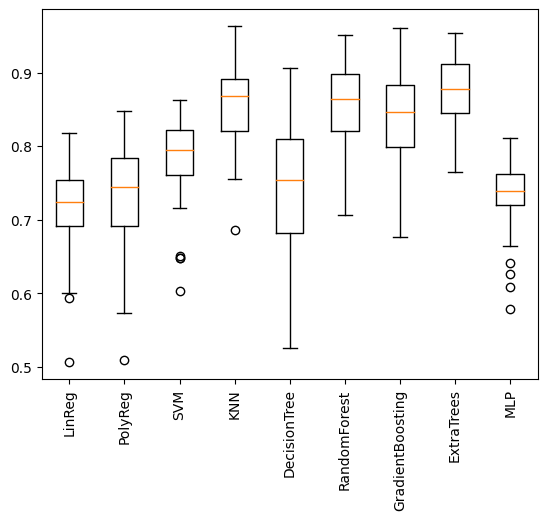

In [46]:
plotter = ResultsCVPlotter()
plotter.plot_cross_val_results(results, names)

Podemos ver que o resultado final dos modelos default deixou bastante a desejar. A métrica `R2`, cujo valor tende a 1 quando o valor previsto se iguala ao valor real da grandeza em todas as amostras atingiu valores da ordem de 0.62 no máximo, com um desvio padrão de quase metade de seu valor, mesmo para os melhores modelos. Também é possível já vislumbrar que os modelos de árvore tiveram uma performance interessante, enquanto o SVM deixou muito a desejar. Cabe ressaltar que a normalização surtiu pouca influência no resultado final.

### Hyperparameter Search

Nessa etapa iremos executar uma busca de hiperparâmetros por meio de um processo de busca randômica. Diferente da busca em grade, esse processo não nos dá controle exato dos parâmetros a serem fornecidos ao modelo, porém tem a vantagem de permitir uma amostragem de valores aleatórios dentro de faixas de variáveis contínuas. Além disso, permite a geração de quantos modelos forem necessários, não sendo necessário se atera o máximo que a grade permite.

Antes de partir para a busca, vamos tirar o SVM da lista de candidatos, uma vez que o modelo é pesado e apresentou baixa performence:

In [47]:
#pipelines = [pipeline for pipeline in pipelines if 'SVM' not in pipeline[0]]

Isso feito, vamos sortear para cada modelo um total de 100 candidatos e performar validação cruzada para determinar o melhor modelo:

In [48]:
n_iterations = 100
hyperparameter_search = RandomizedHyperParameterSearch()
best_models = hyperparameter_search.search_best_hyperparameters(pipelines, X_train, y_train, cv=cv, score=scorer, iters=n_iterations)

  0%|          | 0/9 [00:00<?, ?it/s]

 89%|████████▉ | 8/9 [17:36<02:12, 132.12s/it]


ValueError: Invalid parameter 'activation' for estimator Pipeline(steps=[('MLP', MLPRegressor(random_state=85))]). Valid parameters are: ['memory', 'steps', 'verbose'].

Comparando os resultados usando os mesmo objetos de antes:

In [ ]:
results, names, ranking = compareCV.perform_cross_validation(best_models, X_train, y_train, cv=cv, score=scorer)

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [04:54<00:00, 10.51s/it]


In [ ]:
display(ranking)

,MODEL,MEAN,STD_DEV
14,MinMax_KNN,0.865051,0.054348
15,Standard_KNN,0.864767,0.061547
13,Robust_KNN,0.859037,0.063951
2,KNN,0.858391,0.061971
24,Standard_GradientBoosting,0.858116,0.056851
22,Robust_GradientBoosting,0.858089,0.057083
5,GradientBoosting,0.857989,0.057067
23,MinMax_GradientBoosting,0.857860,0.057292
4,RandomForest,0.849829,0.051193
21,Standard_RandomForest,0.849812,0.051190


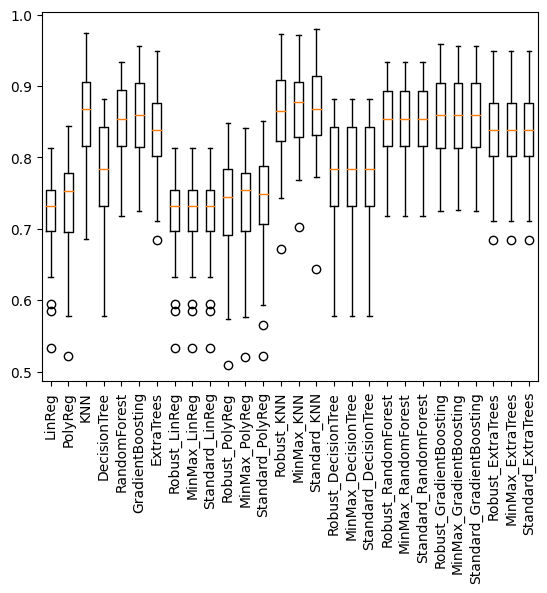

In [ ]:
plotter = ResultsCVPlotter()
plotter.plot_cross_val_results(results, names)

Vemos agora que tanto o desvio padrão reduzio para os melhores modelos quanto o valor médio do score também melhoru, chegando a 0.7. Do lado dos melhores modelos, houve uma troca do ExtraTrees para o Gradient Boosting como o melhor modelo, novamente com a normalização apresentando pouco impacto.

## Pos-processamento

Nessa etapa vamos fazer tanto comparações gráficas quanto de métricas para avaliar qual dos modelos seria melhor. Diferente do processo de CV, para esse rankeamento usaremos o valor do `MAE` como métrica balizadora.

### Implementando as classes

As classes para essa etapa serão apenas um avaliador numérico, quegerará uma representação tabular das métricas de erro em treino e teste e um avaliador gráfico, que mostrará a série temporal final para comparação. Ambas são montadas abaixo:

In [ ]:
class Evaluator:
    """Simple class to perform metric evaluation on train and test
    sets
    """

    def __init__(self, verbose=False):

        self.verbose = verbose

    def evaluate_models(self, models, X_train, y_train, X_test, y_test, metrics):

        results = {
            'MODEL':[],
        }

        for metric_name, _ in metrics:
            results[metric_name + '_TRAIN'] = []
            results[metric_name + '_TEST'] = []

        results['INFERENCE_TIME'] = []

        for model_tuple in tqdm(models):

            name, model = model_tuple[0], model_tuple[1]
            results['MODEL'].append(name)

            t0 = datetime.datetime.utcnow()
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            dt = datetime.datetime.utcnow() - t0

            results['INFERENCE_TIME'].append(dt)

            for metric_name, metric, kwargs in metrics:
                results[metric_name + '_TRAIN'].append(metric(y_train, y_train_pred, **kwargs))
                results[metric_name + '_TEST'].append(metric(y_test, y_test_pred, **kwargs))

        return pd.DataFrame(results)

class GraphicalEvaluator:
    """Class that creates simple visualization of the results as a continuous timeseries, with
    train and test sets being sinalized. Works on model lists.
    """

    def plot_prediction_comparison(self, models, X_train, y_train, X_test, y_test):

        for model_tuple in models:
            name, model = model_tuple[0], model_tuple[1]
            
            fig, ax   = plt.subplots(1,1, figsize=(12,7))

            number_of_train_samples = len(y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            y_total = y_train.tolist() + y_test.tolist()
            number_of_total_samples = len(y_total)
            y_total_pred = y_train_pred.tolist() + y_test_pred.tolist()

            ax.plot(y_total_pred, 'r', label='PREDICTED DATA')
            ax.plot(y_total, 'k--', label='REAL DATA')

            ax.fill_between(
                np.arange(0, number_of_total_samples), np.min(y_total), np.max(y_total), 
                where = np.arange(0, number_of_total_samples) <= number_of_train_samples,
                facecolor ='grey', alpha = 0.25,
                label='Test data region')
            
            ax.set_title(name)
            ax.set_xlim(0,None)
            ax.set_ylim(np.min(y_total), np.max(y_total))
            ax.legend()





Visualizando a métrica e ordenando pelo `MAE` do teste:

In [ ]:
evaluator = Evaluator()
results = evaluator.evaluate_models(best_models, X_train, y_train, X_test, y_test, metrics)
display(results.sort_values(by='MAE_TEST', ascending=True))

100%|██████████| 28/28 [00:00<00:00, 49.60it/s]


,MODEL,R2_TRAIN,R2_TEST,MSE_TRAIN,MSE_TEST,MAE_TRAIN,MAE_TEST,INFERENCE_TIME
14,MinMax_KNN,0.999995,0.862021,1.000000,36259.486664,0.069498,90.898552,0 days 00:00:00.014275
2,KNN,0.999995,0.848665,1.000000,39769.384320,0.069498,91.982098,0 days 00:00:00.030432
27,Standard_ExtraTrees,0.920877,0.848509,15779.865900,39810.344964,54.999551,93.147806,0 days 00:00:00.004154
25,Robust_ExtraTrees,0.920877,0.848509,15779.865900,39810.344964,54.999551,93.147806,0 days 00:00:00.005746
26,MinMax_ExtraTrees,0.920877,0.848509,15779.865900,39810.344964,54.999551,93.147806,0 days 00:00:00.008786
6,ExtraTrees,0.920877,0.848509,15779.865900,39810.344964,54.999551,93.147806,0 days 00:00:00.004056
13,Robust_KNN,0.999995,0.851724,1.000000,38965.542156,0.069498,93.360696,0 days 00:00:00.012029
15,Standard_KNN,0.999995,0.845857,1.000000,40507.202118,0.069498,93.641935,0 days 00:00:00.004081
21,Standard_RandomForest,0.958244,0.796030,8327.542643,53601.261692,44.804908,128.436549,0 days 00:00:00.035553
20,MinMax_RandomForest,0.958244,0.796022,8327.469475,53603.340913,44.801662,128.444701,0 days 00:00:00.061691


Novamente, o gradient boosting se mostra o melhor modelo. Mais que isso, o modelo se mostrou efetivo independente da normalização. Tendo isso em mente, a escolha de modelo final seria pelo modelo sem normalização, de modo a simplificar ao máximo o pipeline. O tempo de inferência reportado também foi inferior a 0.005 segundos para as mais de 700 amostrras avaliadas, indicando que o modelo não só é robusto como tem tempo de inferência inferior em ordens de grandeza a qualquer modelo baseado em simulação comercialmente disponível.

Partimos agora para a avalição gráfica, focando apenas nos modelos de Gradient Boosting:

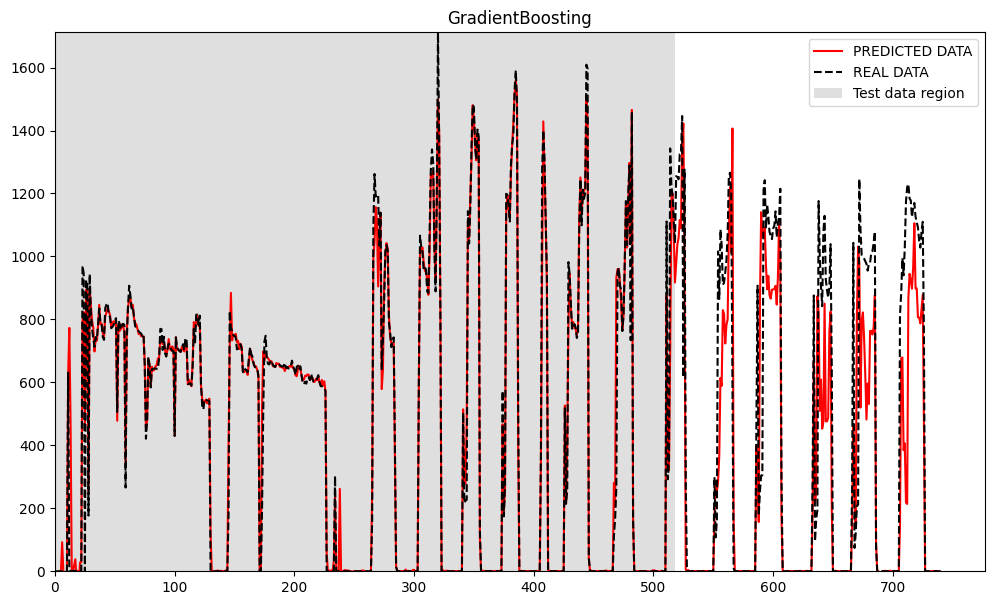

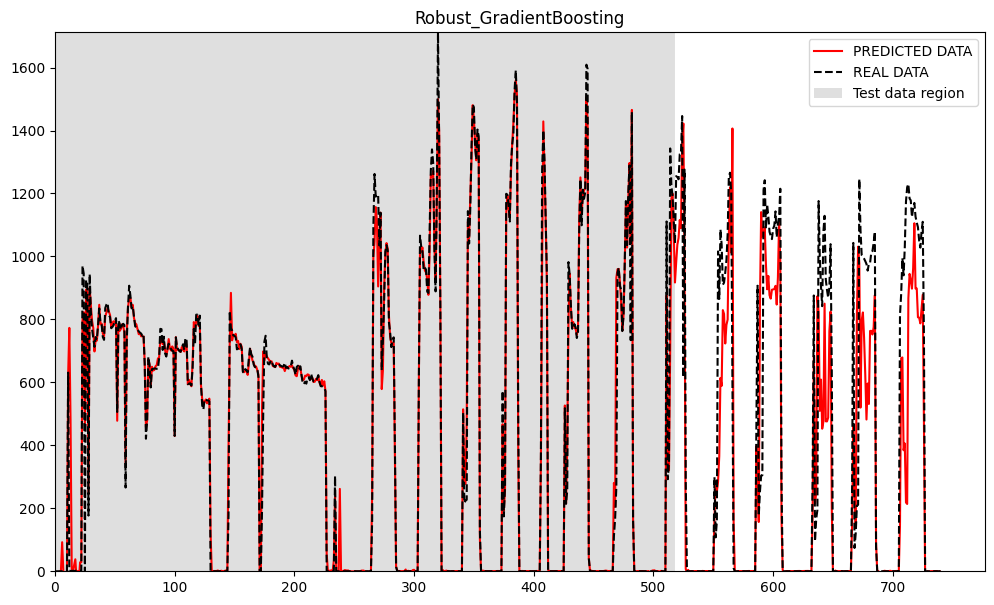

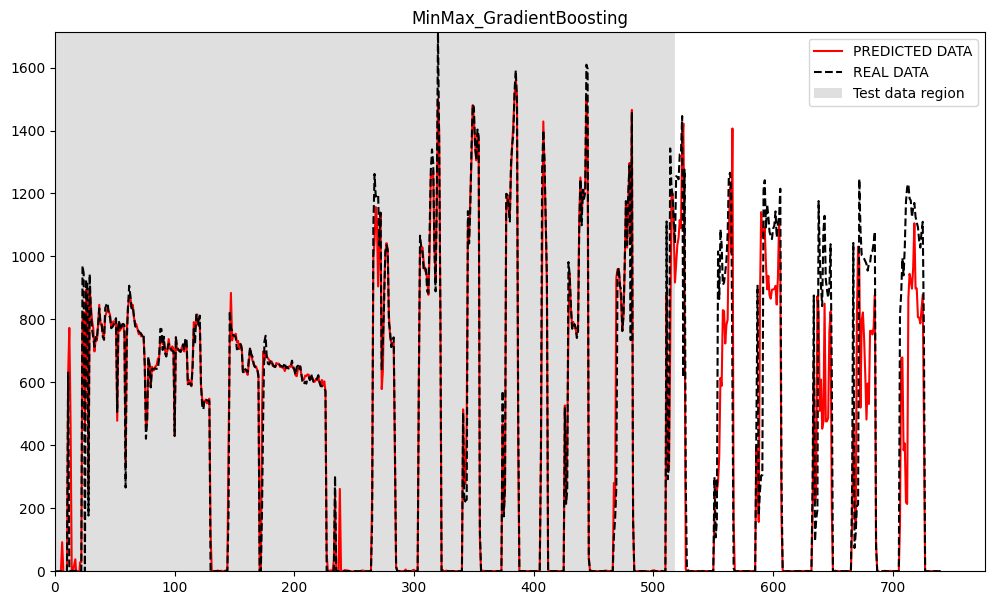

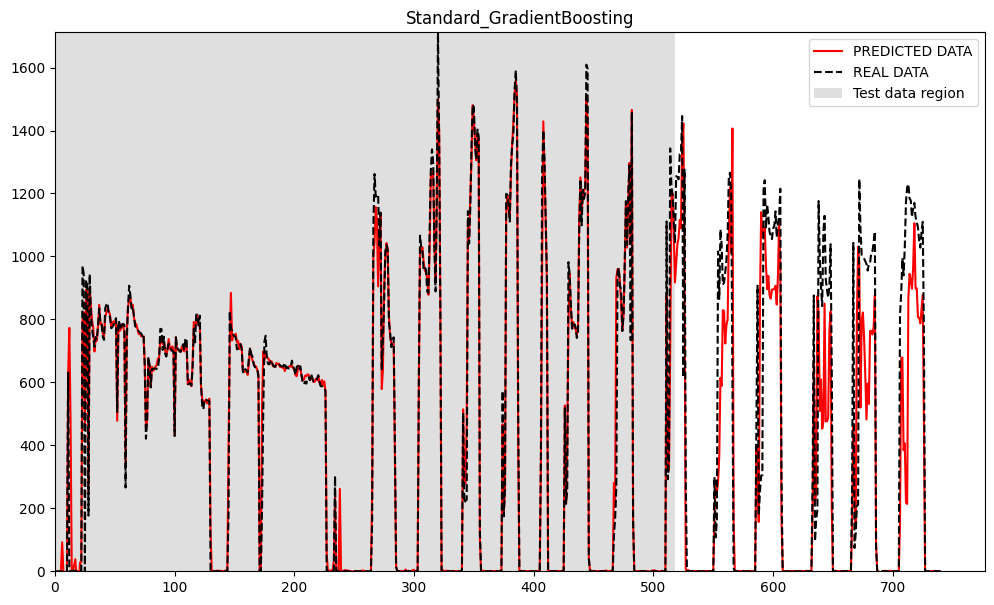

In [ ]:
graphical_evaluator = GraphicalEvaluator()
plot_models = [model for model in best_models if 'GradientBoosting' in model[0]]
graphical_evaluator.plot_prediction_comparison(plot_models, X_train, y_train, X_test, y_test)

Visualmente, os resultados apresentam excelente aderência à série temporal estudada. Podemos seguir com o modelo em questão.

## Apresentação de resultados

Para a etapa de apresentação de resultados, os gráficos gerados na fase de pós-processamento seriam suficientes para comprovar a qualidade do modelo. Em conjunto, seria válido também apresentar as métricas de tempo de inferência, uma vez que isso comprova a vantagem da abordagem frente à simulação clássica.

## Implantação

### Classes

Nesta seção serão encapsuladas em classes apenas um preprocessador aplicável a todo dataset (sem dividir em treino e teste) e uma classe para salvamento do modelo.

In [ ]:
class WellDataProductionPreProcessor(CleanDataPreProcessor, IOSplitPreProcessor):
    """Preprocessor that contemplates all the steps for the dataset in production.
    """

    def __init__(self, input_variables, output_variables, clean_data=True):

        self.set_clean_data(clean_data)

        CleanDataPreProcessor.__init__(self)
        IOSplitPreProcessor.__init__(self, input_variables, output_variables)
    
    def set_clean_data(self, clean_data):

        self.clean_data = clean_data

    def preprocess(self, dataset):

        if self.clean_data:
            dataset = CleanDataPreProcessor.preprocess(self, dataset)
        X, y = IOSplitPreProcessor.preprocess(self, dataset)

        return X, y
    

class ModelSave:
    """Class responsible to save the model.
    """

    def save_model(self, model_tuple, fname):
        
        with open(fname, 'wb') as pklfile:
            pkl.dump(model_tuple, pklfile)


### Salvando o modelo

Antes de pensar em implantar o modelo, devemos salvá-lo. Selecionando o Gradient Boosting:

In [ ]:
# Selecionando modelo
best_model = [model for model in best_models if 'GradientBoosting' == model[0]][0]

# Treinando com todo o dataset
production_preprocessor = WellDataProductionPreProcessor(input_variables, output_variables)
X, y = production_preprocessor.preprocess(well_data)
best_model[1].fit(X, y)

# Exportando
model_file = 'best_model.pkl'
model_saver = ModelSave()
#model_saver.save_model(best_model, model_file)

### Próximos passos para implementar

Para o uso do resultado pelo usuário final, seria conveniente por o resultado em um ambiente que ele já use e conheça. A sugestão seria fazer uso do ambiente Plant Inspector (PI), um software comercial para consolidação, armazenamento e visualização de dados temporais em tempo real. Essa ferramenta ainda conta com facilidades como API REST, permitindo sua comunicação com microsserviços via protocolo http. A sugestão de implantação seria seguir os seguintes passos:

* Levantar uma infraestrutura em contênier com especificações suficientes para que o modelo performe com a agilidade necessária
* Escrever código mínimo de integração dedicado a:
    * puxar, via protocolo http, os valores dos sensores e válvulas do PI (inputs do modelo)
    * inferir a partir do modelo
    * publicar esses valores como uma tag extra no PI, para consumo pelo usuário final

